### 12 LeNet on New Plant Diseases

### LeNet model for New-Plant Diseases Data

In this notebook, we will apply the LeNet model to a dataset of new-plant diseases. The dataset is retrieved from Kaggle (see for: [New Plant Diseases Dataset](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset).
The notebook is organized in the following structure: 
+ 1. Importing necessary libraries for preprocessing and training the model
+ 2. Setting paths to new-plant-diseases dataset
+ 3. Function to load images and creating arrays of images and labels
+ 4. Data Augmentation and Generators
+ 5. Model Architecture Definition
+ 6. Model Training Setup
+ 7. Model Evaluation and Prediction
+ 8. Confusion Matrix Visualization

In [1]:
# 1. Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#### 2. Setting paths to new-plant-diseases dataset
Sets the paths to the dataset directories and converts them to absolute paths. Prints the current working directory and the absolute paths for verification.

In [2]:
# dataset directories
script_dir = os.getcwd()
train_path = os.path.join(script_dir, "..", "src", "data", "new-plant-diseases", "normalized", "train")
test_path = os.path.join(script_dir, "..", "src", "data", "new-plant-diseases", "normalized", "valid")

# converting to absolute paths
absolut_train = os.path.abspath(train_path)
absolut_test = os.path.abspath(test_path)

# Ensuring that paths exist
print("Current path:", script_dir)
print("Absolute training path:", absolut_train)
print("Absolute test path:", absolut_test)

Current path: c:\Program Files (x86)\Projects\Plants\june24_bds_int_plant_reco\notebooks
Absolute training path: c:\Program Files (x86)\Projects\Plants\june24_bds_int_plant_reco\src\data\new-plant-diseases\normalized\train
Absolute test path: c:\Program Files (x86)\Projects\Plants\june24_bds_int_plant_reco\src\data\new-plant-diseases\normalized\valid


#### 3. Function to load images and creating arrays of images and labels
Loads images from a directory, resizes them to (64, 64), normalizes pixel values between [0,1], and converts them to arrays. Further assigns and encodes labels based on directory structure. Returns arrays of images and their corresponding labels.

In [3]:
# Function to load images and labels
def load_images_and_labels(data_dir, target_size=(64, 64)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            filepath = os.path.join(class_dir, filename)
            image = tf.keras.preprocessing.image.load_img(filepath, target_size=target_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
            images.append(image_array)
            labels.append(class_indices[class_name])

    return np.array(images), np.array(labels)

#### 4 Data Augmentation and Generators Setup
Sets up data augmentation for training with various transformations and normalization for validation. Creates data generators for both training and validation datasets, resizing images and setting batch sizes. Determines the number of classes from the training data.

In [4]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only normalization for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=64,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=64,
    class_mode='categorical'
)

# Number of classes based on the training data
num_classes = train_generator.num_classes

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


#### 5 LeNet Model Architecture and Compilation
Defines the LeNet Model with layers including convolutional, max-pooling, dropout, flatten, and dense. Compiles the model with categorical crossentropy loss and the Adam optimizer, and displays the model summary.

In [5]:
# Layer Definition
inputs = Input(shape=(64, 64, 3), name="Input")

conv_1 = Conv2D(filters=30,
                kernel_size=(5, 5),
                padding='valid',
                activation='relu',
                input_shape=(64, 64, 3))

max_pool_1 = MaxPooling2D(pool_size=(2, 2))

conv_2 = Conv2D(filters=16,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')

max_pool_2 = MaxPooling2D(pool_size=(2, 2))

dropout = Dropout(rate=0.2)

flatten = Flatten()

dense_1 = Dense(units=128, activation='relu')

dense_2 = Dense(units=num_classes, activation='softmax')  # Anzahl der Klassen dynamisch anpassen

# Model architecture
x = conv_1(inputs)
x = max_pool_1(x)
x = conv_2(x)
x = max_pool_2(x)

x = dropout(x)
x = flatten(x)
x = dense_1(x)
outputs = dense_2(x)

# Create the model
lenet = Model(inputs=inputs, outputs=outputs)

# Compile Model
lenet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lenet.summary()

c:\Users\janze\anaconda3\envs\plantenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 60, 30)     │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,054 (1.58 MB)

 Trainable params: 413,054 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

#### 6 Model Training Setup
Calculates the number of steps per epoch for training and validation. Defines callbacks for early stopping and model checkpointing, then trains the model using these settings.

In [6]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = lenet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


c:\Users\janze\anaconda3\envs\plantenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 375s 339ms/step - accuracy: 0.2321 - loss: 2.7523 - val_accuracy: 0.5695 - val_loss: 1.3802
Epoch 2/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - accuracy: 0.5938 - loss: 1.3860 - val_accuracy: 0.5833 - val_loss: 1.3912
Epoch 3/50


c:\Users\janze\anaconda3\envs\plantenv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 81s 73ms/step - accuracy: 0.5590 - loss: 1.4359 - val_accuracy: 0.6409 - val_loss: 1.1873
Epoch 4/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.6094 - loss: 1.1579 - val_accuracy: 0.5556 - val_loss: 1.4077
Epoch 5/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 79s 72ms/step - accuracy: 0.6490 - loss: 1.1256 - val_accuracy: 0.6674 - val_loss: 1.1084
Epoch 6/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.7500 - loss: 0.8541 - val_accuracy: 0.6389 - val_loss: 1.2043
Epoch 7/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - accuracy: 0.6978 - loss: 0.9623 - val_accuracy: 0.7522 - val_loss: 0.7806
Epoch 8/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.7656 - loss: 0.8076 - val_accuracy: 0.6389 - val_loss: 1.1785
Epoch 9/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.7229 - loss: 0.8705 - val_accuracy: 0.6470 - val_loss: 1.2036
Epoch 10/50
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.6094 - loss: 1.3118 

#### 7 Model Evaluation and Prediction
Loads validation data, performs one-hot encoding on labels, evaluates the model's accuracy, and makes predictions. Extracts predicted and true labels which then can be displayed in further step.

In [7]:
# Load and evaluate on validation data
X_valid, y_valid = load_images_and_labels(test_path)

# One-Hot-Encoding of labels
y_valid = to_categorical(y_valid, num_classes=num_classes)

# Evaluate the model on the validation set
loss, accuracy = lenet.evaluate(X_valid, y_valid)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Make predictions on the validation set
predictions = lenet.predict(X_valid)

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_valid, axis=1)

550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7014 - loss: 0.9221
Validation Accuracy: 75.20%
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


#### 8 Confusion Matrix Visualization
Computes and visualizes the confusion matrix as a heatmap, showing the performance of the model on the validation data with class labels.

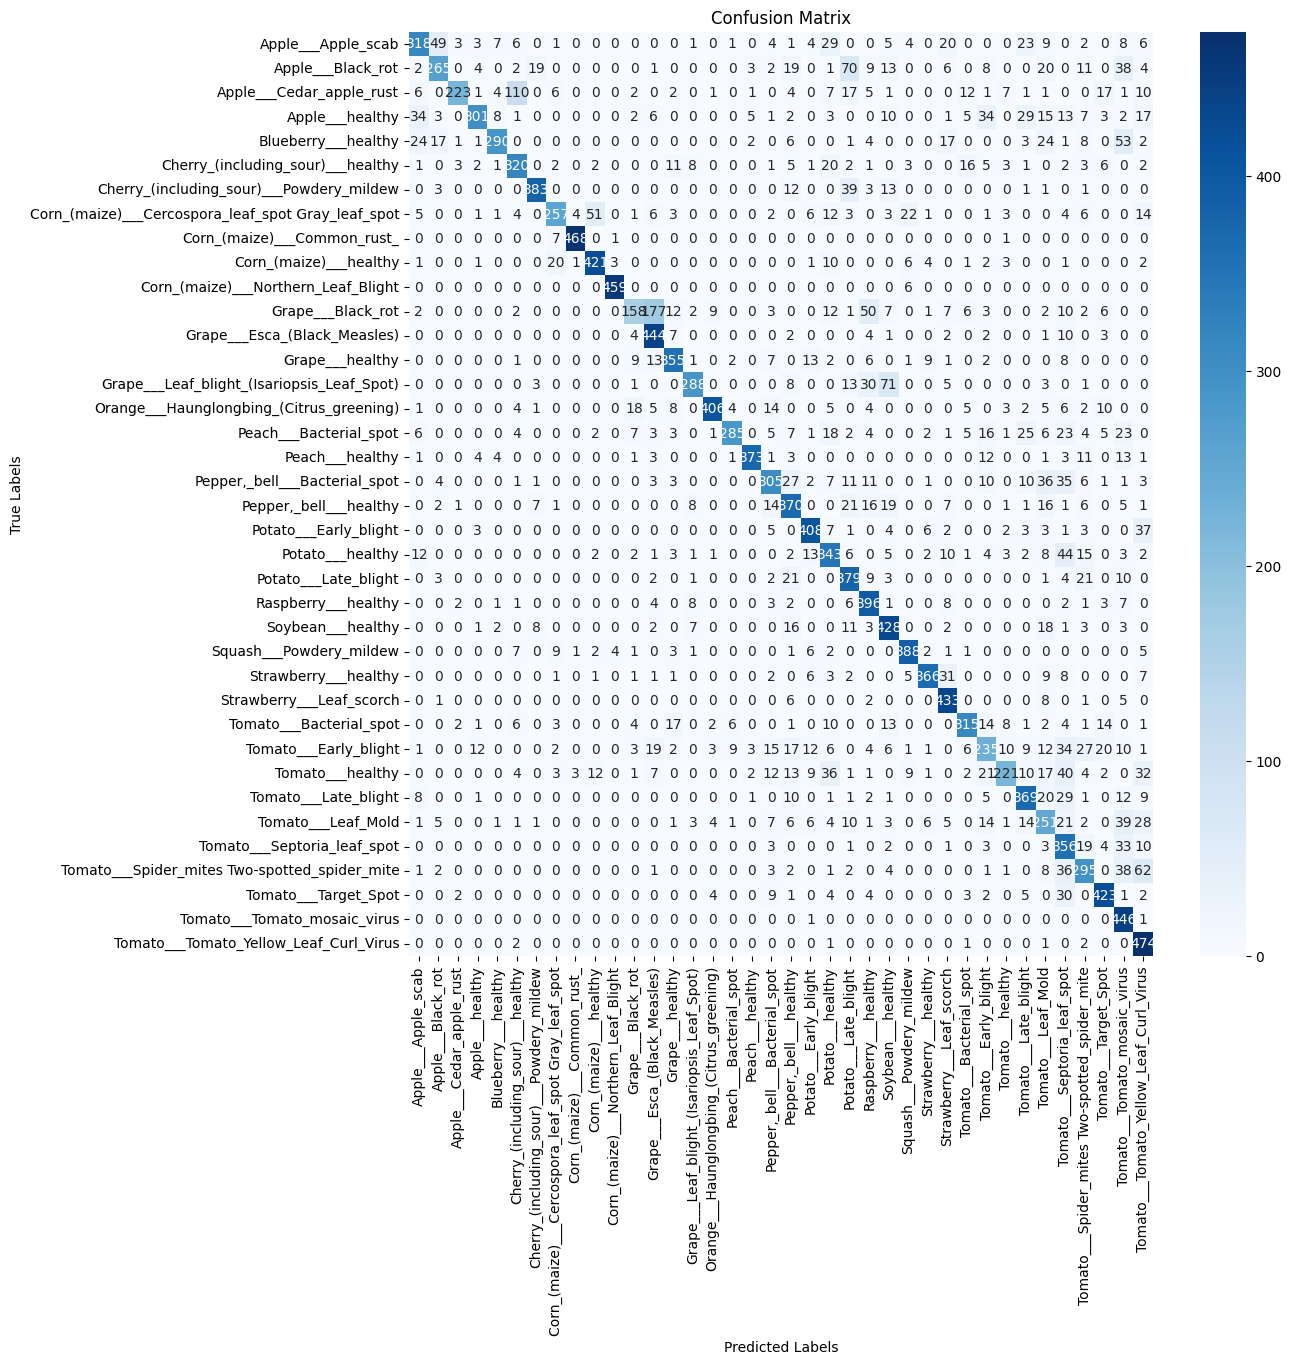

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(os.listdir(test_path))

# Visualize as heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()